In [2]:
pip install torch -i https://mirrors.aliyun.com/pypi/simple/

Looking in indexes: https://mirrors.aliyun.com/pypi/simple/
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [15]:
import numpy as np
import pandas as pd  #读取csv文件的库
import torch
from torch.autograd import Variable
import torch.optim as optim
import matplotlib.pyplot as plt
#让输出图形直接在Notebook中显示



In [16]:
data_path = 'bike-sharing/hour.csv'  #读取数据到内存，rides为一个dataframe对象
rides = pd.read_csv(data_path)
# rides.head() 此条为输出部分数据


类型变量的大小没有任何含义，只是为了区分不同的类型而已。
比如季节这个变量可以等于1、2、3、4，即四季，数字仅仅是对它们的区分。
我们不能将season变量直接输入神经网络，因为season数值并不表示相应的信号强度。
我们的解决方案是将类型变量转化为“独热编码”（one-hot）

In [17]:
seasonsType = {1:[1,0,0,0],2:[0,1,0,0],3:[0,0,1,0],4:[0,0,0,1]}
seasonsType

{1: [1, 0, 0, 0], 2: [0, 1, 0, 0], 3: [0, 0, 1, 0], 4: [0, 0, 0, 1]}

采用这种编码后，不同的数值就转变为了不同的向量，这些向量的长度都是4，而只有一个位置为1，其他位置都是0。
1代表激活，于是独热编码的向量就对应了不同的激活模式。
这样的数据更容易被神经网络处理。
更一般地，如果一个类型变量有n个不同的取值，那么我们的独热编码所对应的向量长度就为n。 

我们稍微变化一下数据，将原来的season变为4列的新值

In [18]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday'] #所有类型编码变量的名称
for each in dummy_fields:
    #取出所有类型变量，并将它们转变为独热编码
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    #将新的独热编码变量与原有的所有变量合并到一起
    rides = pd.concat([rides, dummies], axis=1)

#将原来的类型变量从数据表中删除
fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 'weekday', 'atemp', 'mnth', 'workingday', 
    'hr'] #要删除的类型变量的名称
data = rides.drop(fields_to_drop, axis=1) #将它们从数据库的变量中删除

data

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0000,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0000,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0000,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0000,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0000,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,1,0,0.26,0.60,0.1642,11,108,119,1,0,...,0,0,0,0,1,0,0,0,0,0
17375,1,0,0.26,0.60,0.1642,8,81,89,1,0,...,0,0,0,0,1,0,0,0,0,0
17376,1,0,0.26,0.60,0.1642,7,83,90,1,0,...,1,0,0,0,1,0,0,0,0,0
17377,1,0,0.26,0.56,0.1343,13,48,61,1,0,...,0,1,0,0,1,0,0,0,0,0


数值类型变量的问题在于每个变量的变化范围都不一样，单位也不一样，因此不同的变量就不能进行比较。我们采取的解决方法就是对这种变量进行标准化处理，也就是用变量的均值和标准差来对该变量做标准化，从而都转变为[-1, 1]区间内波动的数值。比如，对于温度temp这个变量来说，它在整个数据库中取值的平均值为mean(temp)，方差为std(temp)，那么，归一化的温度计算为：


归一化方法
本文使用均值和标准差
在分类、聚类算法中，需要使用距离来度量相似性的时候、或者使用PCA技术进行降维的时候，新的数据由于对方差进行了归一化，这时候每个维度的量纲其实已经等价了，每个维度都服从均值为0、方差1的正态分布，在计算距离的时候，每个维度都是去量纲化的，避免了不同量纲的选取对距离计算产生的巨大影响。

In [19]:
quant_features = ['cnt', 'temp', 'hum', 'windspeed'] #数值类型变量的名称
scaled_features = {}  #将每一个变量的均值和方差都存储到scaled_features变量中
means, stds = list(),list()
for each in quant_features:
    #计算这些变量的均值和方差
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    #对每一个变量进行归一化
    data.loc[:, each] = (data[each] - mean)/std
    means.append(mean)
    stds.append(std)
data

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,-1.334609,0.947345,-1.553844,3,13,-0.956312,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,-1.438475,0.895513,-1.553844,8,32,-0.823998,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,-1.438475,0.895513,-1.553844,5,27,-0.868103,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,-1.334609,0.636351,-1.553844,3,10,-0.972851,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,-1.334609,0.636351,-1.553844,0,1,-1.039008,1,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,1,0,-1.230743,-0.141133,-0.211685,11,108,-0.388467,1,0,...,0,0,0,0,1,0,0,0,0,0
17375,1,0,-1.230743,-0.141133,-0.211685,8,81,-0.553859,1,0,...,0,0,0,0,1,0,0,0,0,0
17376,1,0,-1.230743,-0.141133,-0.211685,7,83,-0.548346,1,0,...,1,0,0,0,1,0,0,0,0,0
17377,1,0,-1.230743,-0.348463,-0.456086,13,48,-0.708224,1,0,...,0,1,0,0,1,0,0,0,0,0


首先，在变量集合上，我们分为了特征和目标两个集合。其中，特征变量集合包括：年份（yr）、是否节假日（holiday）、温度（temp）、湿度（hum）、风速（windspeed）、季节14（season）、天气14（weathersit，不同天气种类）、月份112（mnth）、小时023（hr）和星期0~6（weekday），它们是输入给神经网络的变量。目标变量包括：用户数（cnt）、临时用户数（casual），以及注册用户数（registered）。其中我们仅仅将cnt作为目标变量，另外两个暂时不做任何处理。我们将利用56个特征变量作为神经网络的输入，来预测1个变量作为神经网络的输出。


In [20]:
#将最后一个月的数据作为测试集
test_data = data[-30*24:] #选出训练集
train_data = data[:-30*24] #选出测试集

#目标列包含的字段
target_fields = ['cnt','casual', 'registered'] 

#训练集划分成特征变量列和目标特征列
features, targets = train_data.drop(target_fields, axis=1), train_data[target_fields]

#测试集划分成特征变量列和目标特征列
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

#将数据类型转换为NumPy数组
X = features.values  #将数据从pandas dataframe转换为NumPy
Y = targets['cnt'].values
Y = Y.astype(float)

Y = np.reshape(Y, [len(Y),1]) #把结果集转为一个个list
print(Y)
losses = []


[[-0.95631172]
 [-0.82399838]
 [-0.86810283]
 ...
 [ 0.32823033]
 [ 0.04706448]
 [-0.17345777]]


在数据处理完毕后，我们将构建新的人工神经网络。这个网络有3层：输入层、隐含层和输出层。每个层的尺寸（神经元个数）分别是56、10和1。其中，输入层和输出层的神经元个数分别由数据决定，隐含层神经元个数则根据我们对数据复杂度的预估决定。通常，数据越复杂，数据量越大，就需要越多的神经元。但是神经元过多容易造成过拟合。

In [21]:
#定义神经网络架构，features.shape[1]个输入层单元，10个隐含层，1个输出层
input_size = features.shape[1]
hidden_size = 10
output_size = 1
batch_size = 128

neu = torch.nn.Sequential(
    torch.nn.Linear(input_size, hidden_size),
    torch.nn.Sigmoid(),
    torch.nn.Linear(hidden_size, output_size),
)


In [22]:
cost = torch.nn.MSELoss()
#计算均方误差，这里机器学习也有类似的函数

In [23]:
optimizer = torch.optim.SGD(neu.parameters(), lr = 0.01)
#pytorch自带的优化器，详细功能需要调查

In [24]:
#，本次训练的批次（batch）设置为128
losses = []
for i in range(1000):
    #每128个样本点被划分为一批，在循环的时候一批一批地读取
    batch_loss = []
    #start和end分别是提取一批数据的起始和终止下标
    for start in range(0, len(X), batch_size):
        end = 0
        if start + batch_size < len(X):
            end = start + batch_size
        else:
            end = len(X)
        xx = Variable(torch.FloatTensor(X[start:end]))
        yy = Variable(torch.FloatTensor(Y[start:end]))
        predict = neu(xx)
        loss = cost(predict, yy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.data.numpy())

    #每隔100步输出损失值
    if i % 100==0:
        losses.append(np.mean(batch_loss))
        print('epoch:',i,'loss:', np.mean(batch_loss))




epoch: 0 loss: 0.8941675
epoch: 100 loss: 0.2789996
epoch: 200 loss: 0.23494105
epoch: 300 loss: 0.15709096
epoch: 400 loss: 0.10431043
epoch: 500 loss: 0.084775604
epoch: 600 loss: 0.078098536
epoch: 700 loss: 0.07482039
epoch: 800 loss: 0.07258773
epoch: 900 loss: 0.070755884


Text(0, 0.5, 'MSE')

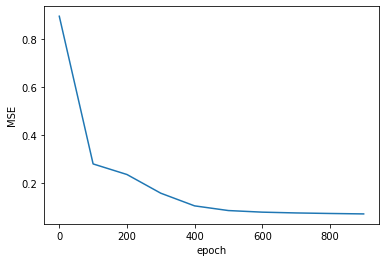

In [25]:
#打印输出损失值
plt.plot(np.arange(len(losses))*100,losses)
plt.xlabel('epoch')
plt.ylabel('MSE')

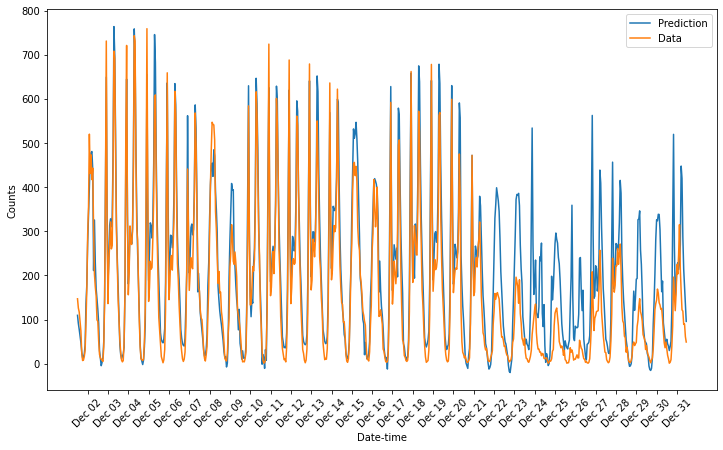

In [26]:
targets = test_targets['cnt']  #读取测试集的cnt数值
targets = targets.values.reshape([len(targets),1])  #将数据转换成合适的tensor形式
#转为实数
targets = targets.astype(float)  

#将特征和结果转为variable
x = Variable(torch.FloatTensor(test_features.values))
y = Variable(torch.FloatTensor(targets))

#用神经网络进行预测
predict = neu(x)
predict = predict.data.numpy()

fig, ax = plt.subplots(figsize = (12, 7))

#反归一化
mean, std = scaled_features['cnt']
ax.plot(predict * std + mean, label='Prediction')
ax.plot(targets * std + mean, label='Data')
ax.legend()
ax.set_xlabel('Date-time')
ax.set_ylabel('Counts')
dates = pd.to_datetime(rides.loc[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)


In [28]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error

mse = mean_squared_error(targets, predict)
evs = explained_variance_score(targets, predict)
print("\n#### xgboost的表现 ####")
print('平均绝对误差:',mean_absolute_error(targets, predict))
print("均方误差:", round(mse, 2))
print("解释方差分:", round(evs, 2))
print("R方值(R2_score)",r2_score(targets, predict))



#### xgboost的表现 ####
平均绝对误差: 0.31016997873335084
均方误差: 0.2
解释方差分: 0.84
R方值(R2_score) 0.7608395281784147


0.7772276146110086